# Road network availability

In this notebook, we analyze road data availability by measuring the actual length of the road network--instead of just bytes of information. In the OSM database, roads are modelled by "way" objects (*i.e.* polylines) with a non-null value for the `highway` property, that describes the type of road (*e.g.* primary, secondary, residential, track, pedestrian, etc.).

<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Geographic-extracts" data-toc-modified-id="Geographic-extracts-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Geographic extracts</a></span></li><li><span><a href="#Road-network-analysis" data-toc-modified-id="Road-network-analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Road network analysis</a></span></li><li><span><a href="#What-types-of-roads-are-mapped?" data-toc-modified-id="What-types-of-roads-are-mapped?-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>What types of roads are mapped?</a></span></li><li><span><a href="#Availability-of-detailed-road-information" data-toc-modified-id="Availability-of-detailed-road-information-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Availability of detailed road information</a></span></li><li><span><a href="#Evolution-of-Detailed-Road-Properties" data-toc-modified-id="Evolution-of-Detailed-Road-Properties-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Evolution of Detailed Road Properties</a></span></li></ul></div>

## Geographic extracts

In [5]:
import os
import pytz
from datetime import datetime
import subprocess
import json
import concurrent.futures

#import osmium
import numpy as np
import pandas as pd
import geopandas as gpd
from fiona import crs
import geojson
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [6]:
INPUT_DIR = os.path.abspath(os.path.join('..', 'data', 'input'))
OUTPUT_DIR = os.path.abspath(os.path.join('..', 'data', 'output'))
OSM_DATAFILE = os.path.join(INPUT_DIR, 'africa-internal-190515.osh.pbf')

In [3]:
africa = gpd.read_file('../data/input/africa.geojson')
africa.set_index('ADMIN', drop=True, inplace=True)
africa.drop(columns='ISO_A3', inplace=True)
# Output data from previous notebook
densities = pd.read_csv('../data/output/osmdb_densities.csv', index_col=0)

* https://oslandia.com/en/2017/07/03/openstreetmap-data-analysis-how-to-parse-the-data-with-python/
* https://osmcode.org/osmium-tool/manual.html#creating-geographic-extracts
* https://github.com/jazzband/python-geojson/issues/84

The following analysis focuses on the road network, so we first filter input data based on the `highway` OSM tag in order to reduce the size of the dataset.

In [4]:
if not os.path.isfile('../data/input/africa-highways.osh.pbf'):

    subprocess.run([
        'osmium', 'tags-filter', '../data/input/africa-190605.osh.pbf', 'w/highway',
        '-o', '../data/input/africa-highways.osh.pbf'
    ])

Then we perform a geographical extract for each country using the `osmium extract` subcommand.

In [6]:
# Create geographical extracts for each country
osmdir = '../data/input/osm'
os.makedirs(osmdir, exist_ok=True)
for country in africa.index:
    
    # Generate ID from country name
    cid = country.replace(' ', '_')

    # Avoid if file already exists
    if os.path.isfile(os.path.join(osmdir, cid + '.osh.pbf')):
        continue

    # Dump geometry into a GeoJSON file
    geom = africa.at[country, 'geometry'].__geo_interface__
    with open('/tmp/geom.geojson', 'w') as f:
        geojson.dump(geojson.Feature(geometry=geom), f)

    # Extract from main OSM datafile with osmium
    subprocess.run([
        'osmium', 'extract', '--with-history',
        '-p', '/tmp/geom.geojson',
        '../data/input/africa-highways.osh.pbf',
        '-o', os.path.join(osmdir, cid + '.osh.pbf')
    ])
    
    os.remove('/tmp/geom.geojson')

## Road network analysis

* https://wiki.openstreetmap.org/wiki/Highways

In [7]:
TAGS = [
    'highway',
    'maxspeed',
    'oneway',
    'width',
    'surface',
    'incline',
    'foot',
    'bicycle',
    'access',
    'bus',
    'tracktype',
    'lit',
    'lanes',
    'sidewalk',
    'crossing'
]

In [10]:
class RoadsHandler(osmium.SimpleHandler):
    
    def __init__(self):
        osmium.SimpleHandler.__init__(self)
        self.data = []
    
    def way(self, w):
        if 'highway' in w.tags:
            try:
                length = osmium.geom.haversine_distance(w.nodes)
            except osmium.InvalidLocationError:
                # Way incomplete (ignore)
                return
            self.data.append([
                w.id,
                w.version,
                pd.Timestamp(w.timestamp),
                w.tags['highway'],
                length
            ])

In [11]:
def snapshot(roads, date):
    """Snapshot of the road network at a specific date."""
    data = roads.query('timestamp <= @date').groupby('osmid').version.max()
    data = data.reset_index()
    return pd.merge(data, roads, on=['osmid', 'version'])

In [12]:
def summarize(roads, date):
    """Total road length per type at a specific date."""
    roads_snapshot = snapshot(roads, date)
    lengths = roads_snapshot.groupby('highway').length.sum().round()
    return lengths / 1000

In [13]:
def history(roads, start_date, end_date, freq='3M'):
    """Evolution of road length for each road type."""
    daterange = pd.date_range(start_date, end_date, freq=freq, tz=pytz.UTC)
    summaries = [summarize(roads, date) for date in daterange]
    evolution = pd.DataFrame(summaries).T
    evolution.columns = [d.strftime('%Y-%m') for d in daterange]
    return evolution

In [21]:
def process(country):
    """Process OSM data for a given country."""
    cid = country.replace(' ', '_')
    handler = RoadsHandler()
    handler.apply_file(os.path.join(osmdir, f'{cid}.osh.pbf'), locations=True)
    columns = ['osmid', 'version', 'timestamp', 'highway', 'length']
    roads = pd.DataFrame(handler.data, columns=columns)
    start = datetime(2010, 1, 1, tzinfo=pytz.UTC)
    end = datetime(2019, 5, 1, tzinfo=pytz.UTC)
    evolution = history(roads, start, end, freq='3M')
    return evolution

In [20]:
os.makedirs('../data/output/roads_availability', exist_ok=True)

with concurrent.futures.ProcessPoolExecutor(max_workers=4) as executor:
    for country, evolution in zip(africa.index, executor.map(process, africa.index)):
        cid = country.replace(' ', '_')
        evolution.to_csv('../data/output/roads_availability/' + cid + '.csv')

## What types of roads are mapped?

In the OSM database, the property `highway` is used to identify the type of the mapped road segments ([see OSM docs](https://wiki.openstreetmap.org/wiki/Key:highway)). For example, in D.R. Congo, as of April 2019:

In [76]:
data_dir = '../data/output/roads_availability'
cid = 'Democratic_Republic_of_the_Congo'
roads = pd.read_csv(os.path.join(data_dir, f'{cid}.csv'), index_col=0)
road_lengths = roads['2019-04'].sort_values(ascending=False).dropna()
display(road_lengths)

unclassified                162160.523
secondary                    76623.655
track                        65164.132
residential                  56002.203
tertiary                     47016.228
road                         40118.183
primary                      40008.008
path                         28317.758
motorway                     14569.337
trunk                         7563.907
service                       1877.551
footway                        739.655
unknown                        342.097
living_street                   79.197
construction                    61.691
proposed                        51.091
tertiary_link                   39.197
bridleway                       18.043
pedestrian                      14.283
17028 RP314 primary             10.806
primary_link                     9.400
trunk_link                       9.285
secondary_link                   4.534
red                              1.769
steps                            1.686
raceway                  

Proportion of each road type in percents:

In [30]:
share = (road_lengths / road_lengths.sum())
display((share * 100).head(10))

unclassified    29.984814
secondary       14.168344
track           12.049384
residential     10.355268
tertiary         8.693687
road             7.418182
primary          7.397810
path             5.236186
motorway         2.693990
trunk            1.398629
Name: 2019-04, dtype: float64

In [33]:
share[:10].sum()

0.9939629314561089

There is many different types of roads -- including errors and typos. But 10 road types make up for 99.4% of the road segments. NB: The value `unclassified` does not refer to a lack of information but to the least important road type in a country's system. From the point of view of OSM, road network hierarchy could be described as such:

1. `motorway`
2. `trunk`
2. `primary`
3. `secondary`
4. `tertiary`
5. `unclassified`
6. `residential`

There is also special road types:

* `living_street`: legal priority of pedestrians over cars;
* `service`: public or private access roads, e.g. in industrial areas;
* `pedestrian`: exclusively available to pedestrians;
* `track`: agricultural use;
* `footway`: footpaths exclusively available to pedestrians;

Finally, the following values indicates incomplete information about the segment:

* `road`: non-identified road segment;
* `path`: non-identified path;
* `unknown`

In [92]:
# Classify road types by hierarchy level
hierarchy = {
    0: ['motorway', 'motorway_link'],
    1: ['trunk', 'trunk_link'],
    2: ['primary', 'primary_link'],
    3: ['secondary', 'secondary_link'],
    4: ['tertiary', 'tertiary_link'],
    5: ['unclassified'],
    6: ['residential', 'road'],
    7: ['living_street', 'track', 'service'],  # Accessible to vehicles
    8: ['footway', 'path', 'pedestrian']  # Not accessible to vehicles
}

# Flat list of all values of interest
of_interest = []
for level, values in hierarchy.items():
    of_interest += values

In [56]:
import seaborn as sns
import altair as alt
alt.renderers.enable('notebook');
from datetime import datetime

In [104]:
# Prepare data for plotting
data = roads.copy()
data.columns = [pd.to_datetime(roads.columns, format='%Y-%m')]
data = data.T.fillna(0)
for col in data.columns:
    if col not in of_interest:
        data = data.drop(columns=col)

TODO:

* One stacked area chart per country?
* Group by hierarchy level?

## Availability of detailed road information

The OSM database is widely used for routing & navigation. Various properties associated with road segments are used to that end, such as:

* `highway`: type of road ;
* `maxspeed`: max. speed of road segment ;
* `width`: width of the road ;
* `surface`: surface of the road ;
* `lanes`: number of lanes ;
* `tracktype`: how well maintained a track or road is ;
* `maxspeed:practical`: expected driving speed ;

The objective here is to quantify the availability of this information to assess their relevance in the context of accessibility mapping.

In [4]:
def _value(tags, prop):
    """Returns property value if available, NaN if not."""
    if prop in tags:
        return tags[prop]
    else:
        return np.NaN

class RoadsHandler(osmium.SimpleHandler):
    
    def __init__(self):
        osmium.SimpleHandler.__init__(self)
        self.data = []

    def way(self, w):
        if 'highway' in w.tags:
            try:
                length = osmium.geom.haversine_distance(w.nodes)
            except osmium.InvalidLocationError:
                # Way incomplete (ignore)
                return
            self.data.append([
                w.id,
                w.version,
                pd.Timestamp(w.timestamp),
                w.tags['highway'],
                _value(w.tags, 'maxspeed'),
                _value(w.tags, 'width'),
                _value(w.tags, 'surface'),
                _value(w.tags, 'lanes'),
                _value(w.tags, 'tracktype'),
                _value(w.tags, 'smoothness'),
                length
            ])

In [5]:
def snapshot(roads, date):
    """Snapshot of the road network at a specific date."""
    data = roads.query('timestamp <= @date').groupby('osmid').version.max()
    data = data.reset_index()
    return pd.merge(data, roads, on=['osmid', 'version'])

In [6]:
def get_tracktypes(data):
    trackdata = data[~pd.isna(data.tracktype)]
    return trackdata.groupby('tracktype').length.sum()

def get_surfaces(data):
    surfacedata = data[~pd.isna(data.surface)]
    return surfacedata.groupby('surface').length.sum()

def get_smoothnesses(data):
    smoothdata = data[~pd.isna(data.smoothness)]
    return smoothdata.groupby('smoothness').length.sum()

def availability(data):
    properties = ['maxspeed', 'width', 'surface', 'lanes', 'tracktype', 'smoothness']
    available = pd.Series(
        index=properties,
        data=[data[~pd.isna(data[prop])].length.sum() for prop in properties]
    )
    return available

def history(roads, start_date, end_date, freq='3M'):
    """Evolution of road length for each road type."""
    daterange = pd.date_range(start_date, end_date, freq=freq, tz=pytz.UTC)
    summaries = [availability(snapshot(roads, date)) for date in daterange]
    evolution = pd.DataFrame(summaries).T
    evolution.columns = [d.strftime('%Y-%m') for d in daterange]
    return evolution

In [7]:
def process(country, extracts_dir):
    """Process OSM data for a given country."""
    cid = country.replace(' ', '_')
    handler = RoadsHandler()
    handler.apply_file(os.path.join(extracts_dir, f'{cid}.osh.pbf'), locations=True)
    columns = ['osmid', 'version', 'timestamp', 'highway', 'maxspeed', 'width',
               'surface', 'lanes', 'tracktype', 'smoothness', 'length']
    roadinfo = pd.DataFrame(handler.data, columns=columns)
    start = datetime(2010, 1, 1, tzinfo=pytz.UTC)
    end = datetime(2019, 5, 1, tzinfo=pytz.UTC)
    evolution = history(roadinfo, start, end, freq='3M') / 1000
    tracktypes = get_tracktypes(snapshot(roadinfo, end)) / 1000
    surfaces = get_surfaces(snapshot(roadinfo, end)) / 1000
    smoothnesses = get_smoothnesses(snapshot(roadinfo, end)) / 1000
    return evolution, tracktypes, surfaces, smoothnesses

In [8]:
extracts_dir = os.path.abspath('../data/input/osm')
output_dir = '../data/output/detailed_road_info'
os.makedirs(output_dir, exist_ok=True)

for country in africa.index:
    cid = country.replace(' ', '_')
    evolution, tracktypes, surfaces, smoothnesses = process(country, extracts_dir)
    evolution.to_csv(os.path.join(output_dir, f'{cid}.csv'))
    tracktypes.to_csv(os.path.join(output_dir, f'{cid}_track.csv'), header=['length'])
    surfaces.to_csv(os.path.join(output_dir, f'{cid}_surface.csv'), header=['length'])
    smoothnesses.to_csv(os.path.join(output_dir, f'{cid}_smoothness.csv'), header=['length'])

## Evolution of Detailed Road Properties

In [73]:
import seaborn

In [90]:
sns.set('notebook', 'whitegrid')

In [7]:
os.chdir(OUTPUT_DIR)

In [10]:
roads = pd.read_csv('roads_availability/Democratic_Republic_of_the_Congo.csv', index_col=0)

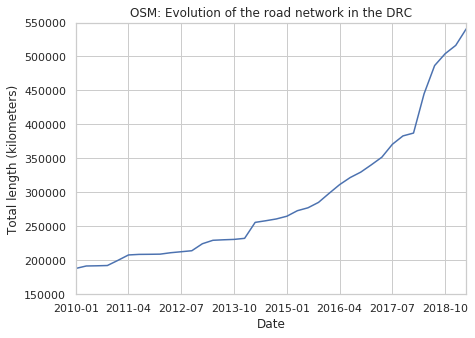

In [102]:
fig = roads.sum().plot(figsize=(7, 5))
fig.set_ylabel('Total length (kilometers)')
fig.set_xlabel('Date')
fig.set_title('OSM: Evolution of the road network in the DRC')
fig.set_ylim(150000, 550000)
plt.savefig('evolution_roads_drc.pdf', bbox_inches='tight')

In [29]:
properties = pd.read_csv('detailed_road_info/Democratic_Republic_of_the_Congo.csv', index_col=0)

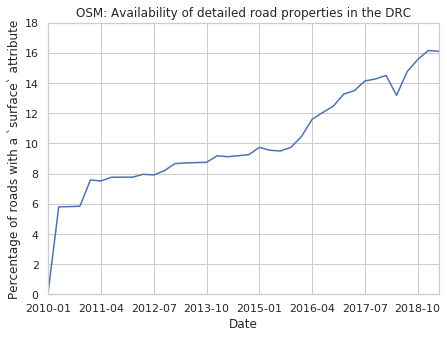

In [101]:
fig = ((properties.loc['surface'] / roads.sum()) * 100).plot(figsize=(7, 5))
fig.set_xlabel('Date')
fig.set_ylabel('Percentage of roads with a `surface` attribute')
fig.set_title('OSM: Availability of detailed road properties in the DRC')
fig.set_ylim(0, 18)
plt.savefig('evolution_properties_drc.pdf', bbox_inches='tight')